# Import The Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import silhouette_score,euclidean_distances
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,silhouette_visualizer
from scipy.cluster.hierarchy import dendrogram,linkage,cophenet
from sklearn.neighbors import NearestNeighbors
np.set_printoptions(suppress=True)
# removing the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# setting the precision of floating numbers to 2 decimal points
pd.set_option("display.float_format", lambda x: "%.3f" % x)
# To plot more advanced plots
import plotly.express as px

# Read The Data

**Column Name - Description**
1. country	 -     Name of the country
2. child_mort -   Death of children under 5 years of age per 1000 live births
3. exports	-      Exports of goods and services per capita. Given as %age of the GDP per capita
4. health -	   Total health spending per capita. Given as %age of GDP per capita
5. imports -	   Imports of goods and services per capita. Given as %age of the GDP per capita
6. Income- 	   Net income per person
7. Inflation -    The measurement of the annual growth rate of the Total GDP
8. life_expec -   The average number of years a new born child would live if the current mortality patterns are to remain the same
9. total_fer -	   The number of children that would be born to each woman if the current age-fertility rates remain the same.
10. gdpp - 	       The GDP per capita. Calculated as the Total GDP divided by the total population.


In [7]:
data = pd.read_csv('Country-data.csv')
data

country  child_mort  exports  health  imports  income  \
0            Afghanistan      90.200   10.000   7.580   44.900    1610   
1                Albania      16.600   28.000   6.550   48.600    9930   
2                Algeria      27.300   38.400   4.170   31.400   12900   
3                 Angola     119.000   62.300   2.850   42.900    5900   
4    Antigua and Barbuda      10.300   45.500   6.030   58.900   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu      29.200   46.600   5.250   52.700    2950   
163            Venezuela      17.100   28.500   4.910   17.600   16500   
164              Vietnam      23.300   72.000   6.840   80.200    4490   
165                Yemen      56.300   30.000   5.180   34.400    4480   
166               Zambia      83.100   37.000   5.890   30.900    3280   

     inflation  life_expec  total_fer   gdpp  
0        9.440      56.200      5.820    553  
1        4.490      76.300      1.650   4090  
2       16.100      76.500      2.890   4460  
3       22.400      60.100      6.160   3530  
4        1.440      76.800      2.130  12200  
..         ...         ...        ...    ...  
162      2.620      63.000      3.500   2970  
163     45.900      75.400      2.470  13500  
164     12.100      73.100      1.950   1310  
165     23.600      67.500      4.670   1310  
166     14.000      52.000      5.400   1460  

[167 rows x 10 columns]

**Setting Country as Index**

In [9]:
data.set_index('country',inplace=True)

# Data Exploration

In [11]:
print(f'No of Countries = {data.shape[0]}')

No of Countries = 167


In [12]:
data.describe().T

count      mean       std     min      25%      50%       75%  \
child_mort 167.000    38.270    40.329   2.600    8.250   19.300    62.100   
exports    167.000    41.109    27.412   0.109   23.800   35.000    51.350   
health     167.000     6.816     2.747   1.810    4.920    6.320     8.600   
imports    167.000    46.890    24.210   0.066   30.200   43.300    58.750   
income     167.000 17144.689 19278.068 609.000 3355.000 9960.000 22800.000   
inflation  167.000     7.782    10.571  -4.210    1.810    5.390    10.750   
life_expec 167.000    70.556     8.893  32.100   65.300   73.100    76.800   
total_fer  167.000     2.948     1.514   1.150    1.795    2.410     3.880   
gdpp       167.000 12964.156 18328.705 231.000 1330.000 4660.000 14050.000   

                  max  
child_mort    208.000  
exports       200.000  
health         17.900  
imports       174.000  
income     125000.000  
inflation     104.000  
life_expec     82.800  
total_fer       7.490  
gdpp       105000.000

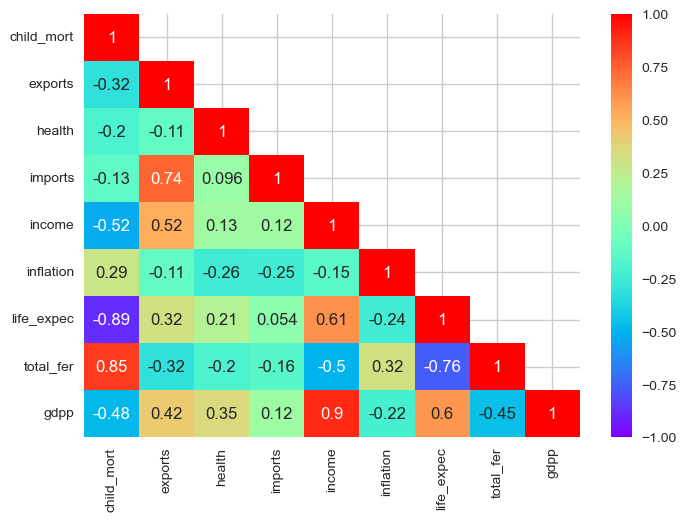

In [13]:
# Lets look at correlation plot
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1,cmap='rainbow',mask=np.triu(data.corr(),k=1))
plt.show()

# Univariate Analysis

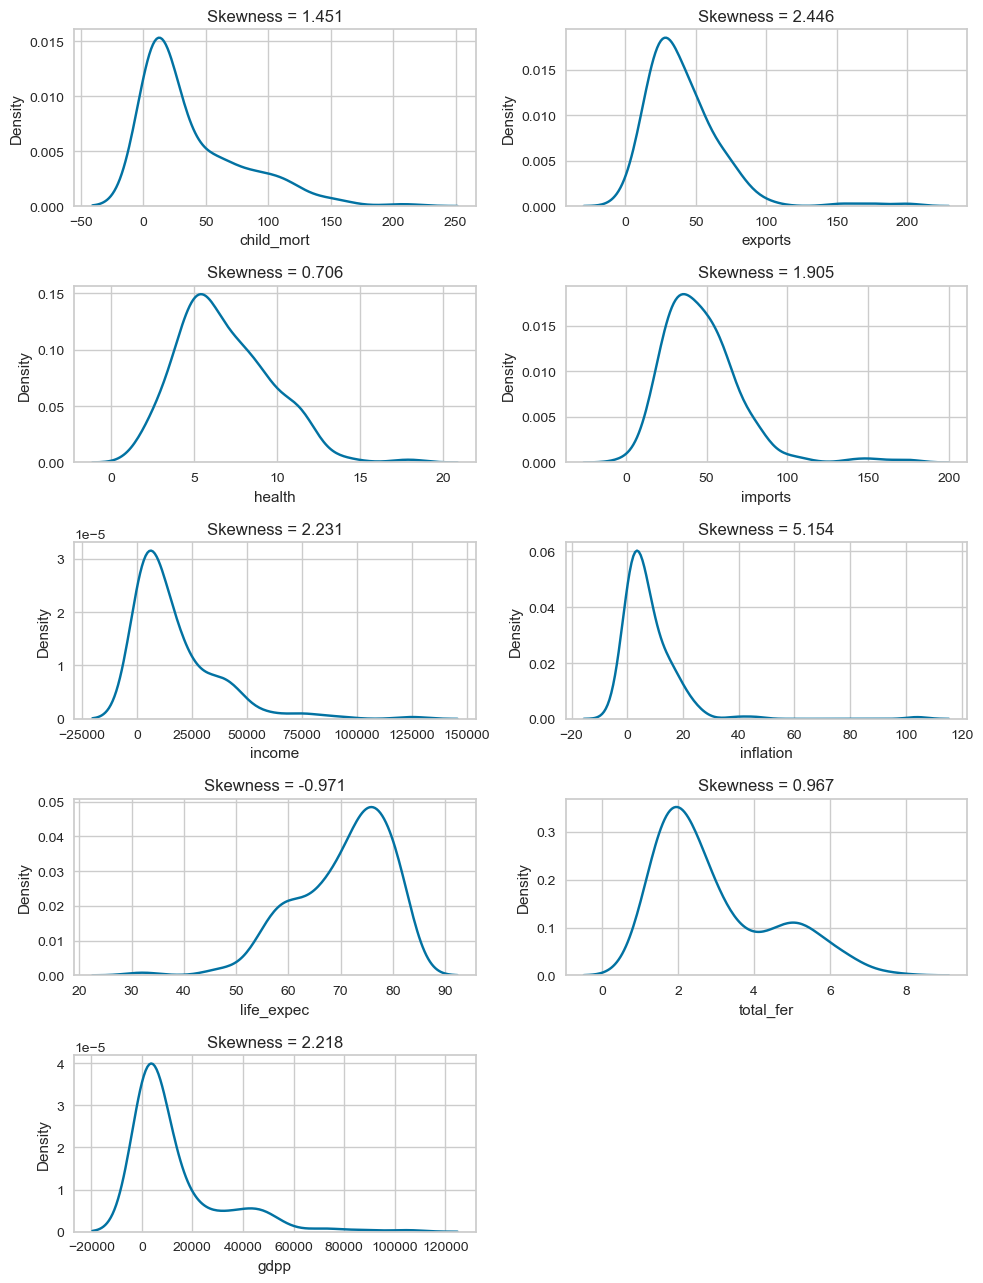

In [15]:
t=1
plt.figure(figsize=(10,13))
for i in data:
    plt.subplot(5,2,t)
    sns.kdeplot(data[i])
    plt.title(f'Skewness = {round(data[i].skew(),3)}')
    t=t+1
plt.tight_layout()
plt.show()

**Inference**
* There is right skewness in child_imports,

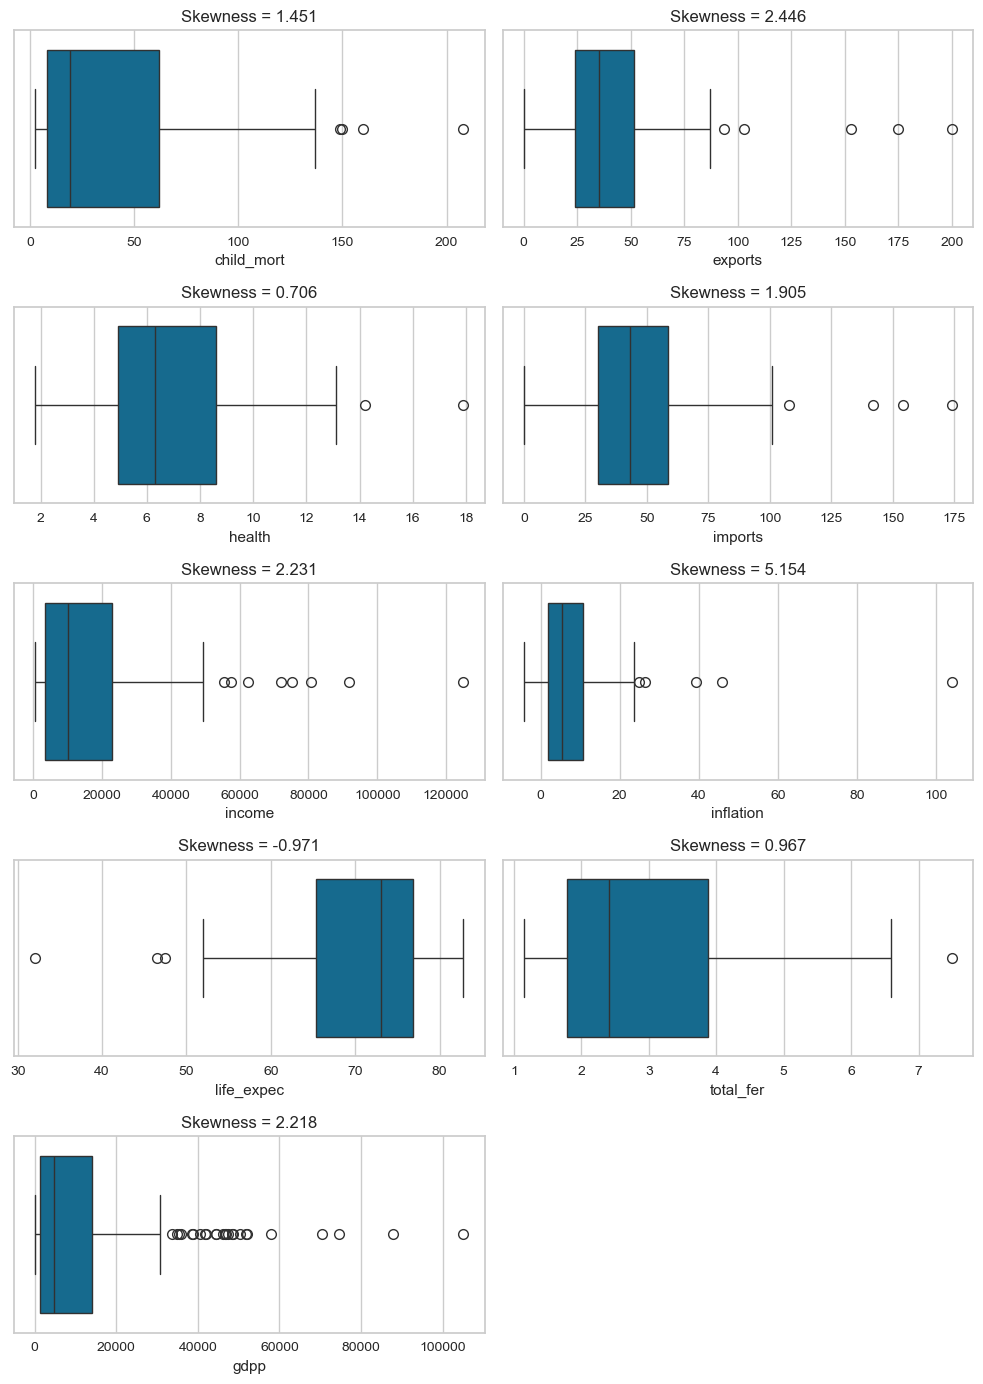

In [17]:
t=1
plt.figure(figsize=(10,14))
for i in data:
    plt.subplot(5,2,t)
    sns.boxplot(data[i],orient='h')
    plt.title(f'Skewness = {round(data[i].skew(),3)}')
    t=t+1
plt.tight_layout()
plt.show()

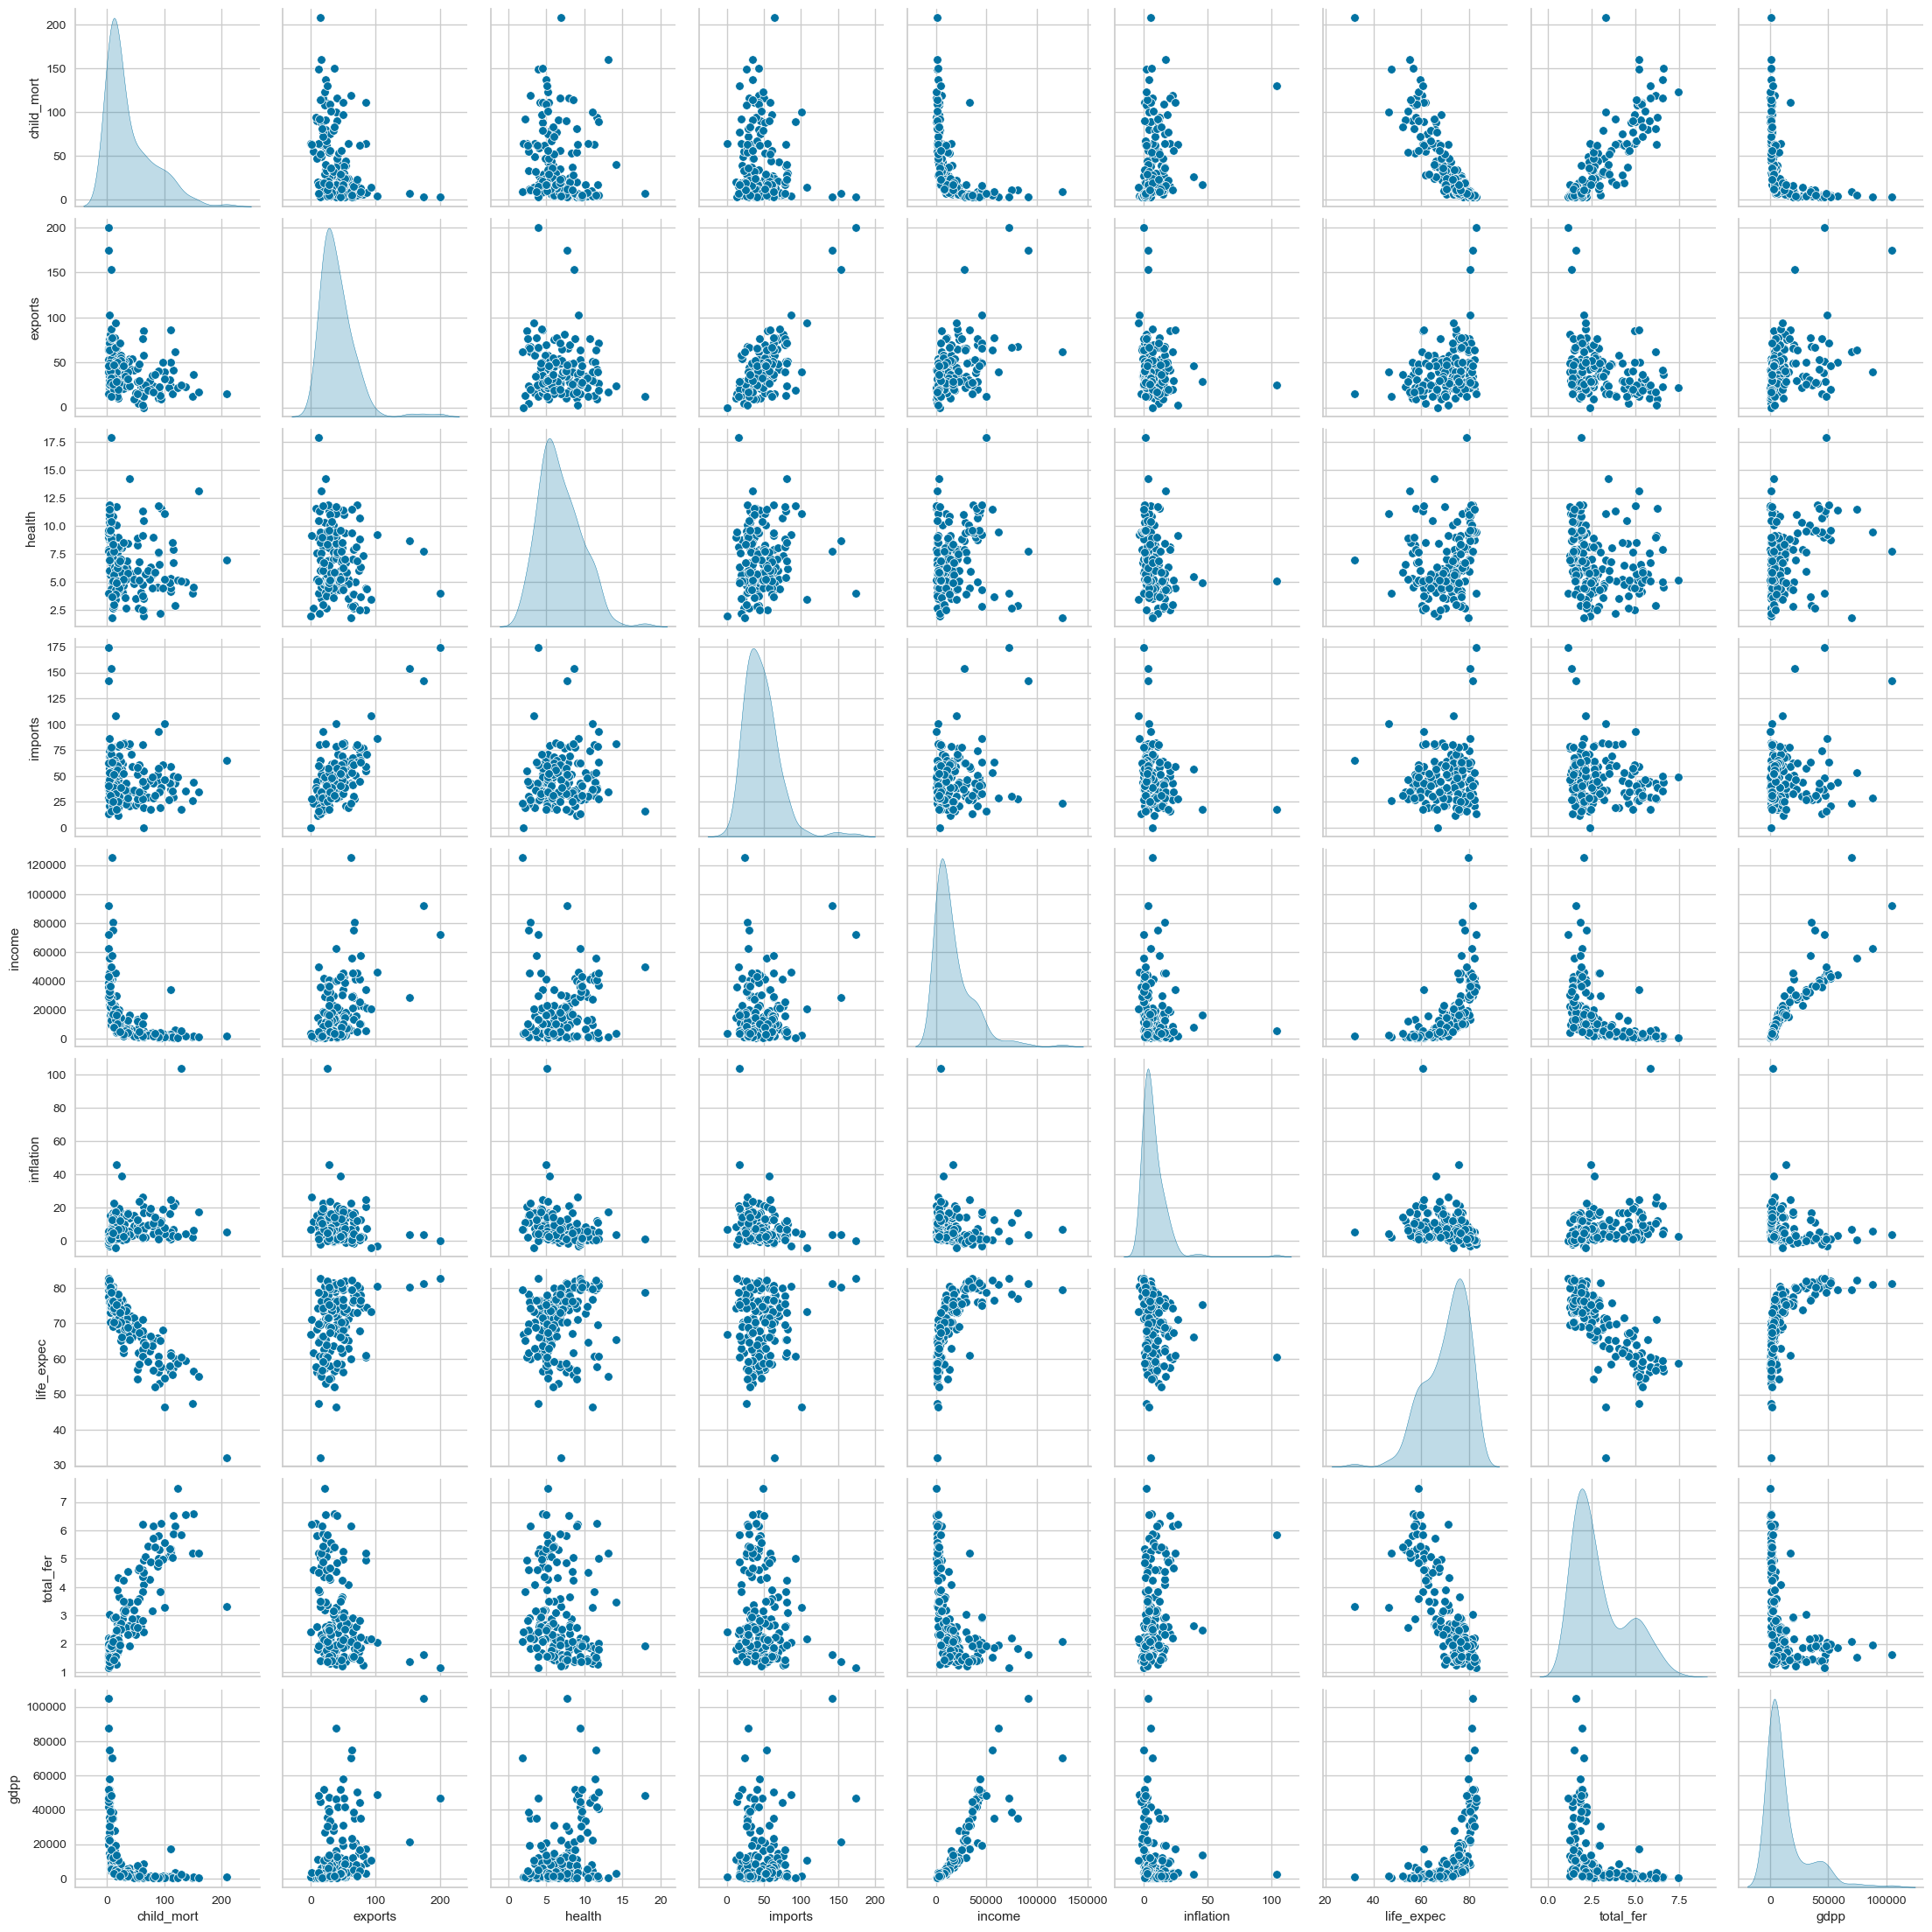

In [18]:
# Pairplot of data
sns.pairplot(data,diag_kind='kde')
plt.show()

# Data Preprocessing

## Check for defects

**Check for missing values**

In [22]:
data.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

`Inference`:
* There are no missing values in data

**Check for duplicated rows**

In [25]:
data[data.duplicated()]

Empty DataFrame
Columns: [child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp]
Index: []

`Inference`:
* There are No duplicated Rows in the data

**Treating The Outliers using capping method with IQR**

In [28]:
for i in data:
    q1,q3 = np.percentile(data[i],[25,75])
    iqr = q3-q1
    ll,ul = q1-1.5*iqr,q3+1.5*iqr
    data[i] = data[i].apply(lambda x:ll if x<ll else ul if x>ul else x)

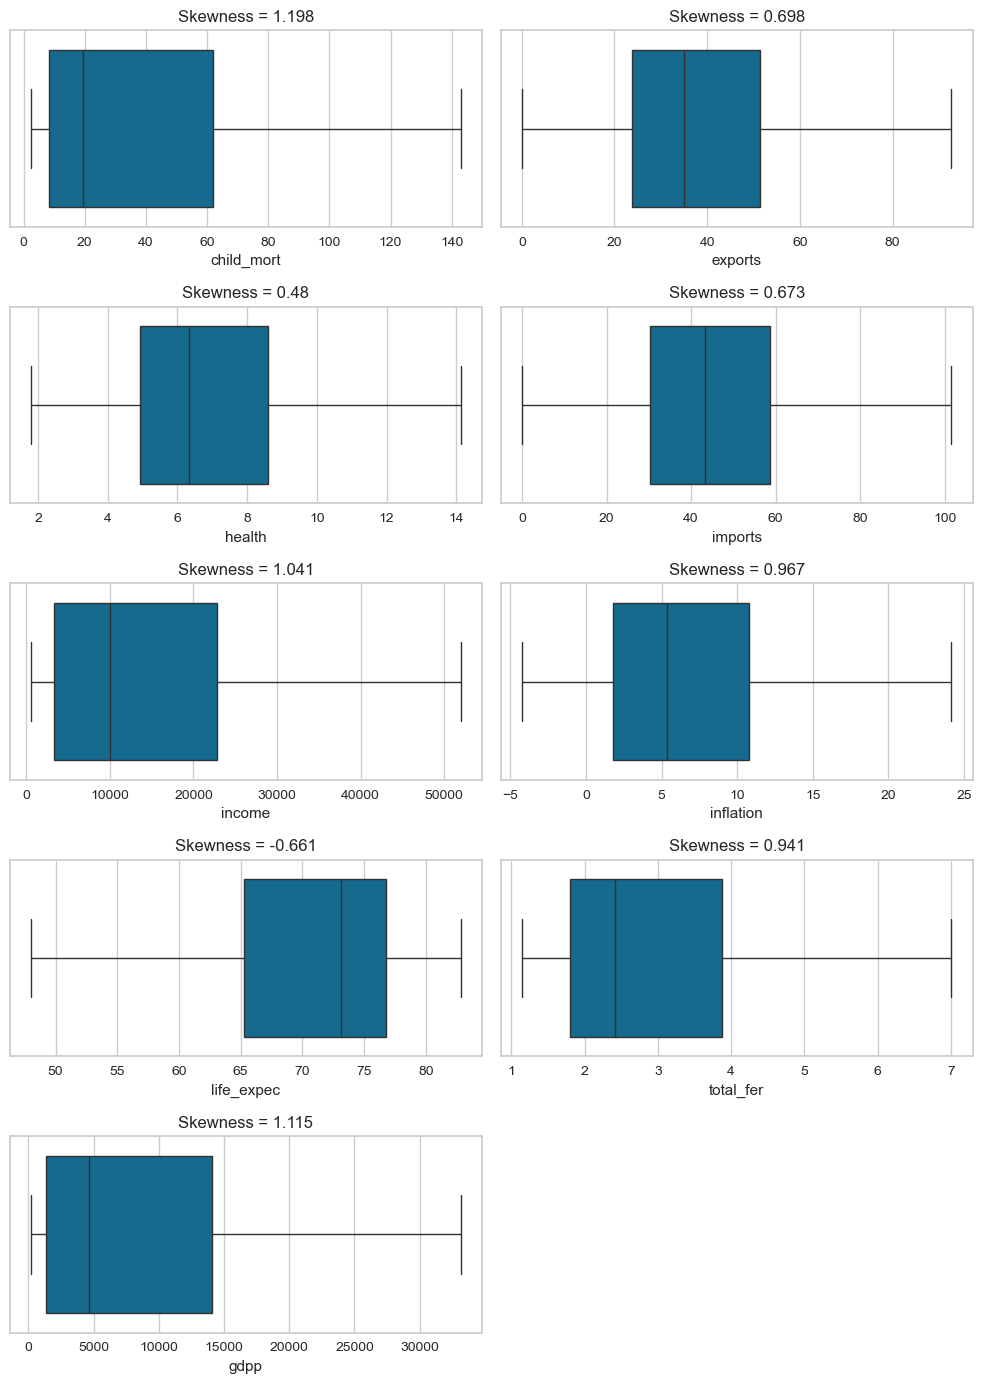

In [29]:
t=1
plt.figure(figsize=(10,14))
for i in data:
    plt.subplot(5,2,t)
    sns.boxplot(data[i],orient='h')
    plt.title(f'Skewness = {round(data[i].skew(),3)}')
    t=t+1
plt.tight_layout()
plt.show()

### We will scale the data for Clustring

In [31]:
sc = StandardScaler()

In [32]:
data_s = sc.fit_transform(data)
data_s = pd.DataFrame(data_s,index=data.index,columns=data.columns)
data_s

child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan               1.370   -1.391   0.296   -0.047  -0.944      0.355   
Albania                  -0.550   -0.544  -0.091    0.135  -0.395     -0.385   
Algeria                  -0.271   -0.054  -0.986   -0.713  -0.199      1.352   
Angola                    2.121    1.072  -1.482   -0.146  -0.661      2.294   
Antigua and Barbuda      -0.715    0.280  -0.287    0.643   0.210     -0.841   
...                         ...      ...     ...      ...     ...        ...   
Vanuatu                  -0.222    0.332  -0.580    0.337  -0.856     -0.665   
Venezuela                -0.537   -0.520  -0.708   -1.394   0.038      2.557   
Vietnam                  -0.376    1.528   0.018    1.693  -0.754      0.753   
Yemen                     0.485   -0.449  -0.606   -0.565  -0.755      2.473   
Zambia                    1.185   -0.120  -0.339   -0.738  -0.834      1.037   

                     life_expec  total_fer   gdpp  
country                                            
Afghanistan              -1.702      1.915 -0.846  
Albania                   0.663     -0.863 -0.541  
Algeria                   0.687     -0.037 -0.509  
Angola                   -1.243      2.142 -0.589  
Antigua and Barbuda       0.722     -0.543  0.160  
...                         ...        ...    ...  
Vanuatu                  -0.902      0.370 -0.638  
Venezuela                 0.557     -0.316  0.272  
Vietnam                   0.287     -0.663 -0.781  
Yemen                    -0.372      1.149 -0.781  
Zambia                   -2.197      1.635 -0.768  

[167 rows x 9 columns]

# PCA (`Principal Component Analysis`)

### For better clusters and better visualization

In [34]:
pca = PCA(n_components=9)

In [35]:
pca.fit(data_s)

PCA(n_components=9)

In [36]:
# Lets use % of explained variances to decide the number of PC's
pca.explained_variance_ratio_.cumsum()

array([0.48892383, 0.65345231, 0.79102018, 0.88606572, 0.95106892,
       0.97118734, 0.98774592, 0.99674059, 1.        ])

In [37]:
pca_Final = PCA(n_components=5)
pca_data = pca_Final.fit_transform(data_s)
pca_data = pd.DataFrame(pca_data,index=data_s.index,columns=['PC1','PC2','PC3','PC4','PC5'])
pca_data

PC1    PC2    PC3    PC4    PC5
country                                               
Afghanistan         -3.178 -0.251 -1.011  0.779 -0.014
Albania              0.435 -0.219 -0.293 -1.391  0.157
Algeria             -0.417 -0.614  1.638 -0.615  0.537
Angola              -3.306  1.067  2.151  1.699  0.161
Antigua and Barbuda  1.253  0.548 -0.137 -0.717 -0.395
...                    ...    ...    ...    ...    ...
Vanuatu             -0.882  0.946 -0.228 -0.680 -0.551
Venezuela           -0.240 -1.742  2.238 -0.081  1.318
Vietnam              0.306  2.153  0.456 -0.746  1.384
Yemen               -2.271 -0.554  1.525  0.314  1.295
Zambia              -3.141  0.025  0.367  0.999  0.007

[167 rows x 5 columns]

# Clustring

### K- Means Clustring

In [40]:
# Lets identify the value of K

# Elbow Plot 
kelbow = KElbowVisualizer(estimator=KMeans(),k=10)

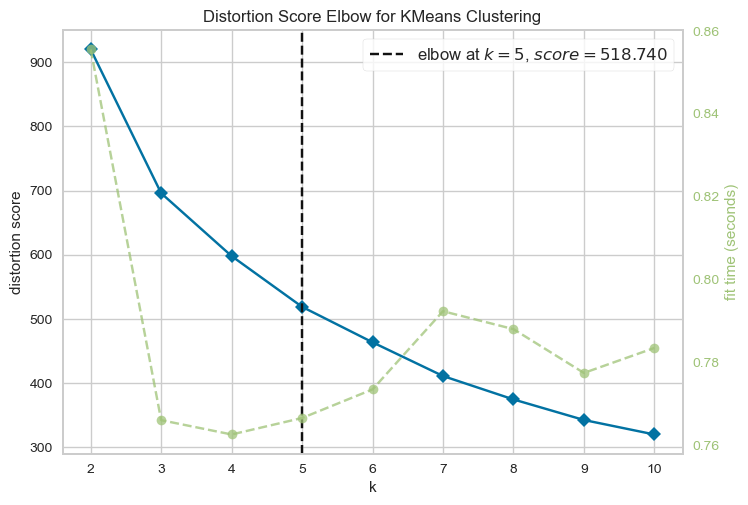

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
kelbow.fit(pca_data)
kelbow.show()

### Silhoutte Visualizer

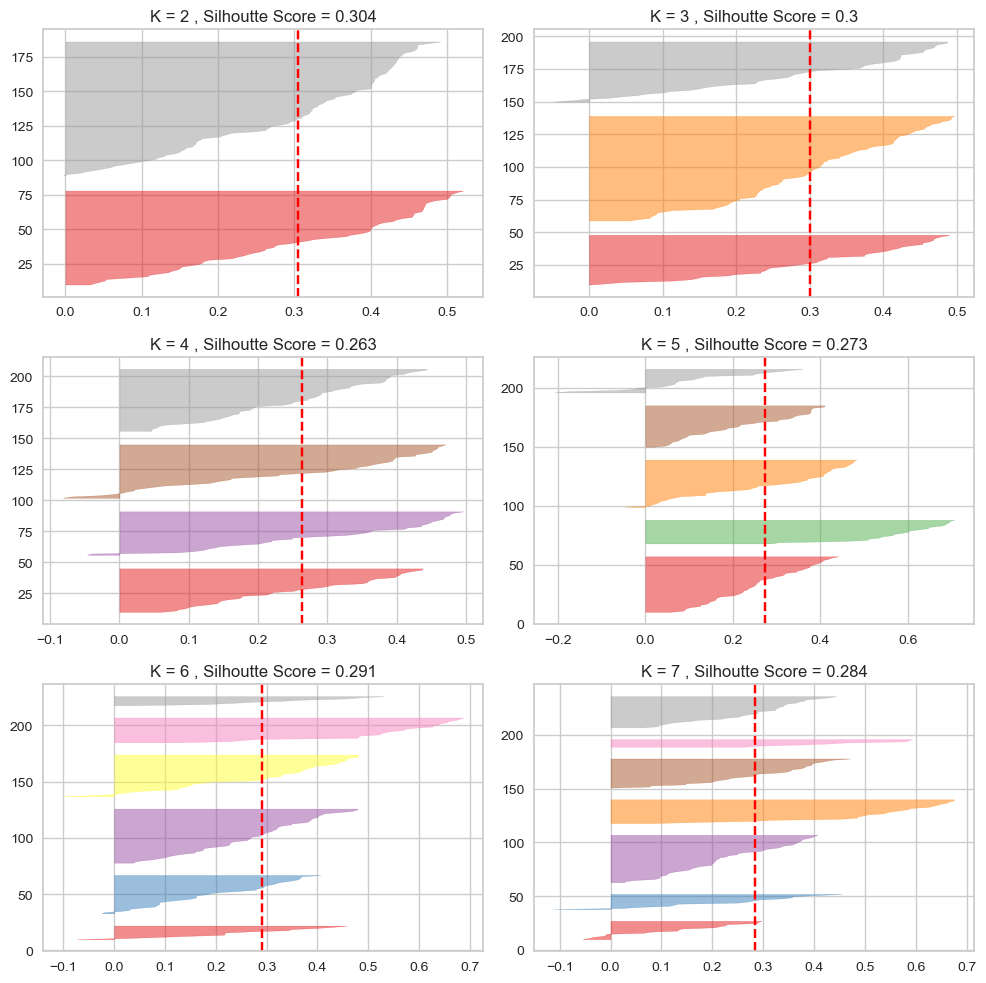

In [43]:
t=1
plt.figure(figsize=(10,10))
for i in range(2,8):
    plt.subplot(3,2,t)
    model = KMeans(n_clusters=i)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(pca_data)
    plt.title(f'K = {i} , Silhoutte Score = {round(sil_viz.silhouette_score_,3)}')
    t=t+1
plt.tight_layout()
plt.show()

**Lets Go with K = 3**
* Reasons:
  1. Although there is no outliers in k = 2 but some significant clusters can be created with k=3
  2. With k = 3 we can have one more cluster with approx same silhoutte score ~0.30

In [45]:
kmean = KMeans(n_clusters=3,random_state=1)
kmean_label = kmean.fit_predict(pca_data)

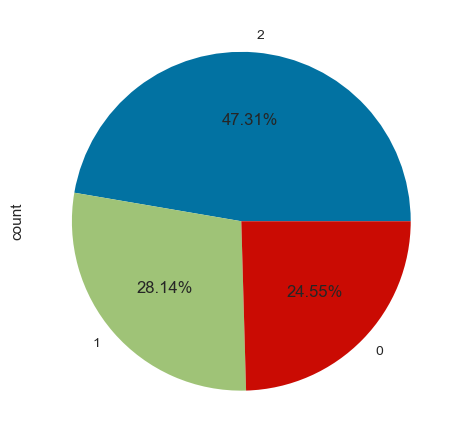

In [46]:
pd.Series(kmean_label).value_counts().plot(kind='pie',autopct = '%.2f%%')
plt.show()

### Visualize the Clusters

In [48]:
centroids = kmean.cluster_centers_
centroids

array([[ 2.76085927, -0.25770328, -0.0018032 ,  0.75648804, -0.23022804],
       [-2.60198555,  0.05658018, -0.19583121,  0.62414201, -0.16900572],
       [ 0.11516571,  0.10008311,  0.11744301, -0.76393271,  0.22003314]])

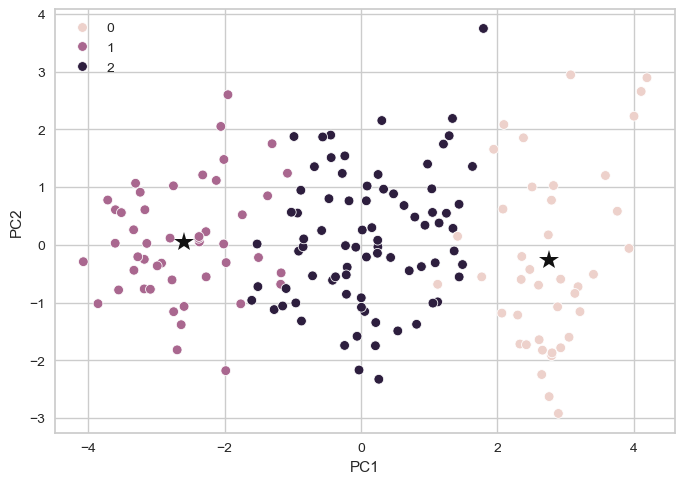

In [49]:
sns.scatterplot(x=pca_data['PC1'],y=pca_data['PC2'],hue=kmean_label)
for i in range(2):
    plt.plot(centroids[i][0],centroids[i][1],marker='*',color = 'k',ms=15)
plt.show()

# Aggloromative Clustring

In [51]:
# Lets make distance matrix and linkage matrix
dist_mat = euclidean_distances(pca_data)
link_mat = linkage(pca_data,method='ward')

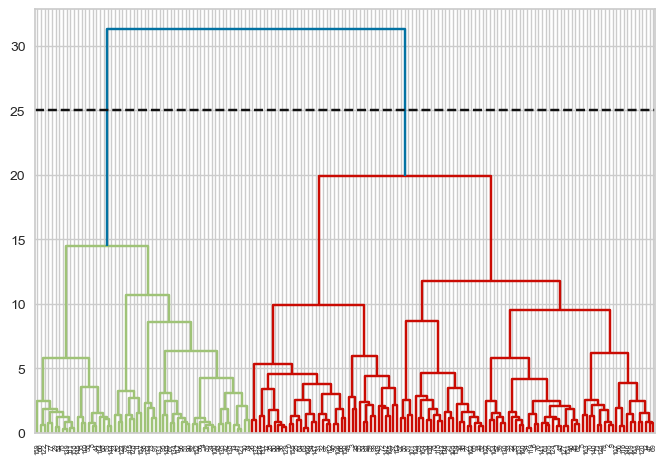

In [52]:
dendrogram(link_mat)
plt.axhline(y=25,color = 'k',ls='--')
plt.show()

**We can go with ward linkage method K = 2**

In [54]:
agglo = AgglomerativeClustering()
agglo_label = agglo.fit_predict(pca_data)

In [55]:
print(f'Silhoutte Score  = {round(silhouette_score(pca_data,agglo_label),3)}')

Silhoutte Score  = 0.303


In [56]:
pd.Series(agglo_label).value_counts()

0    109
1     58
Name: count, dtype: int64

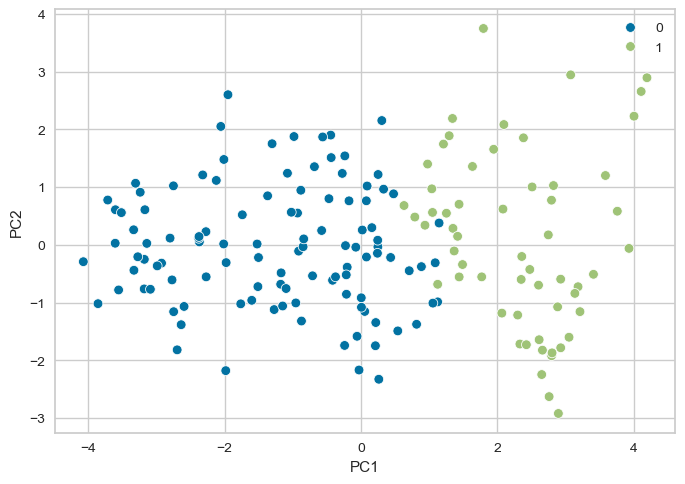

In [57]:
sns.scatterplot(x=pca_data['PC1'],y=pca_data['PC2'],hue=agglo_label)
plt.show()

# Final_Model & Buisness Interpretations
* Both the algorithms gives approx same score .
* Kmeans cluster gives K=3 and Aggloromative cluster gives K=2
* We need to decide which clustring model we should go with.
* Lets go with KMeans as aggloromative is better for heirarchical data,while data has no such heirarchy

In [59]:
data['Label'] = kmean_label

**Business Interpretations**

In [61]:
data.groupby(by='Label').mean()

child_mort  exports  health  imports    income  inflation  life_expec  \
Label                                                                          
0           5.651   52.720   8.332   47.598 38988.780      3.235      79.515   
1          91.183   28.226   6.254   41.233  3738.574     10.215      59.778   
2          22.510   39.439   6.314   47.715 11198.101      7.178      72.547   

       total_fer      gdpp  
Label                       
0          1.800 28969.512  
1          4.988  1808.298  
2          2.324  5771.190

In [62]:
data['Label']=data['Label'].map({0:'Devloped_Countries',1:'Under_Devloped_Countries',2:'Devloping_Countries'})
data

child_mort  exports  health  imports    income  \
country                                                               
Afghanistan              90.200   10.000   7.580   44.900  1610.000   
Albania                  16.600   28.000   6.550   48.600  9930.000   
Algeria                  27.300   38.400   4.170   31.400 12900.000   
Angola                  119.000   62.300   2.850   42.900  5900.000   
Antigua and Barbuda      10.300   45.500   6.030   58.900 19100.000   
...                         ...      ...     ...      ...       ...   
Vanuatu                  29.200   46.600   5.250   52.700  2950.000   
Venezuela                17.100   28.500   4.910   17.600 16500.000   
Vietnam                  23.300   72.000   6.840   80.200  4490.000   
Yemen                    56.300   30.000   5.180   34.400  4480.000   
Zambia                   83.100   37.000   5.890   30.900  3280.000   

                     inflation  life_expec  total_fer      gdpp  \
country                                                           
Afghanistan              9.440      56.200      5.820   553.000   
Albania                  4.490      76.300      1.650  4090.000   
Algeria                 16.100      76.500      2.890  4460.000   
Angola                  22.400      60.100      6.160  3530.000   
Antigua and Barbuda      1.440      76.800      2.130 12200.000   
...                        ...         ...        ...       ...   
Vanuatu                  2.620      63.000      3.500  2970.000   
Venezuela               24.160      75.400      2.470 13500.000   
Vietnam                 12.100      73.100      1.950  1310.000   
Yemen                   23.600      67.500      4.670  1310.000   
Zambia                  14.000      52.000      5.400  1460.000   

                                        Label  
country                                        
Afghanistan          Under_Devloped_Countries  
Albania                   Devloping_Countries  
Algeria                   Devloping_Countries  
Angola               Under_Devloped_Countries  
Antigua and Barbuda       Devloping_Countries  
...                                       ...  
Vanuatu                   Devloping_Countries  
Venezuela                 Devloping_Countries  
Vietnam                   Devloping_Countries  
Yemen                Under_Devloped_Countries  
Zambia               Under_Devloped_Countries  

[167 rows x 10 columns]

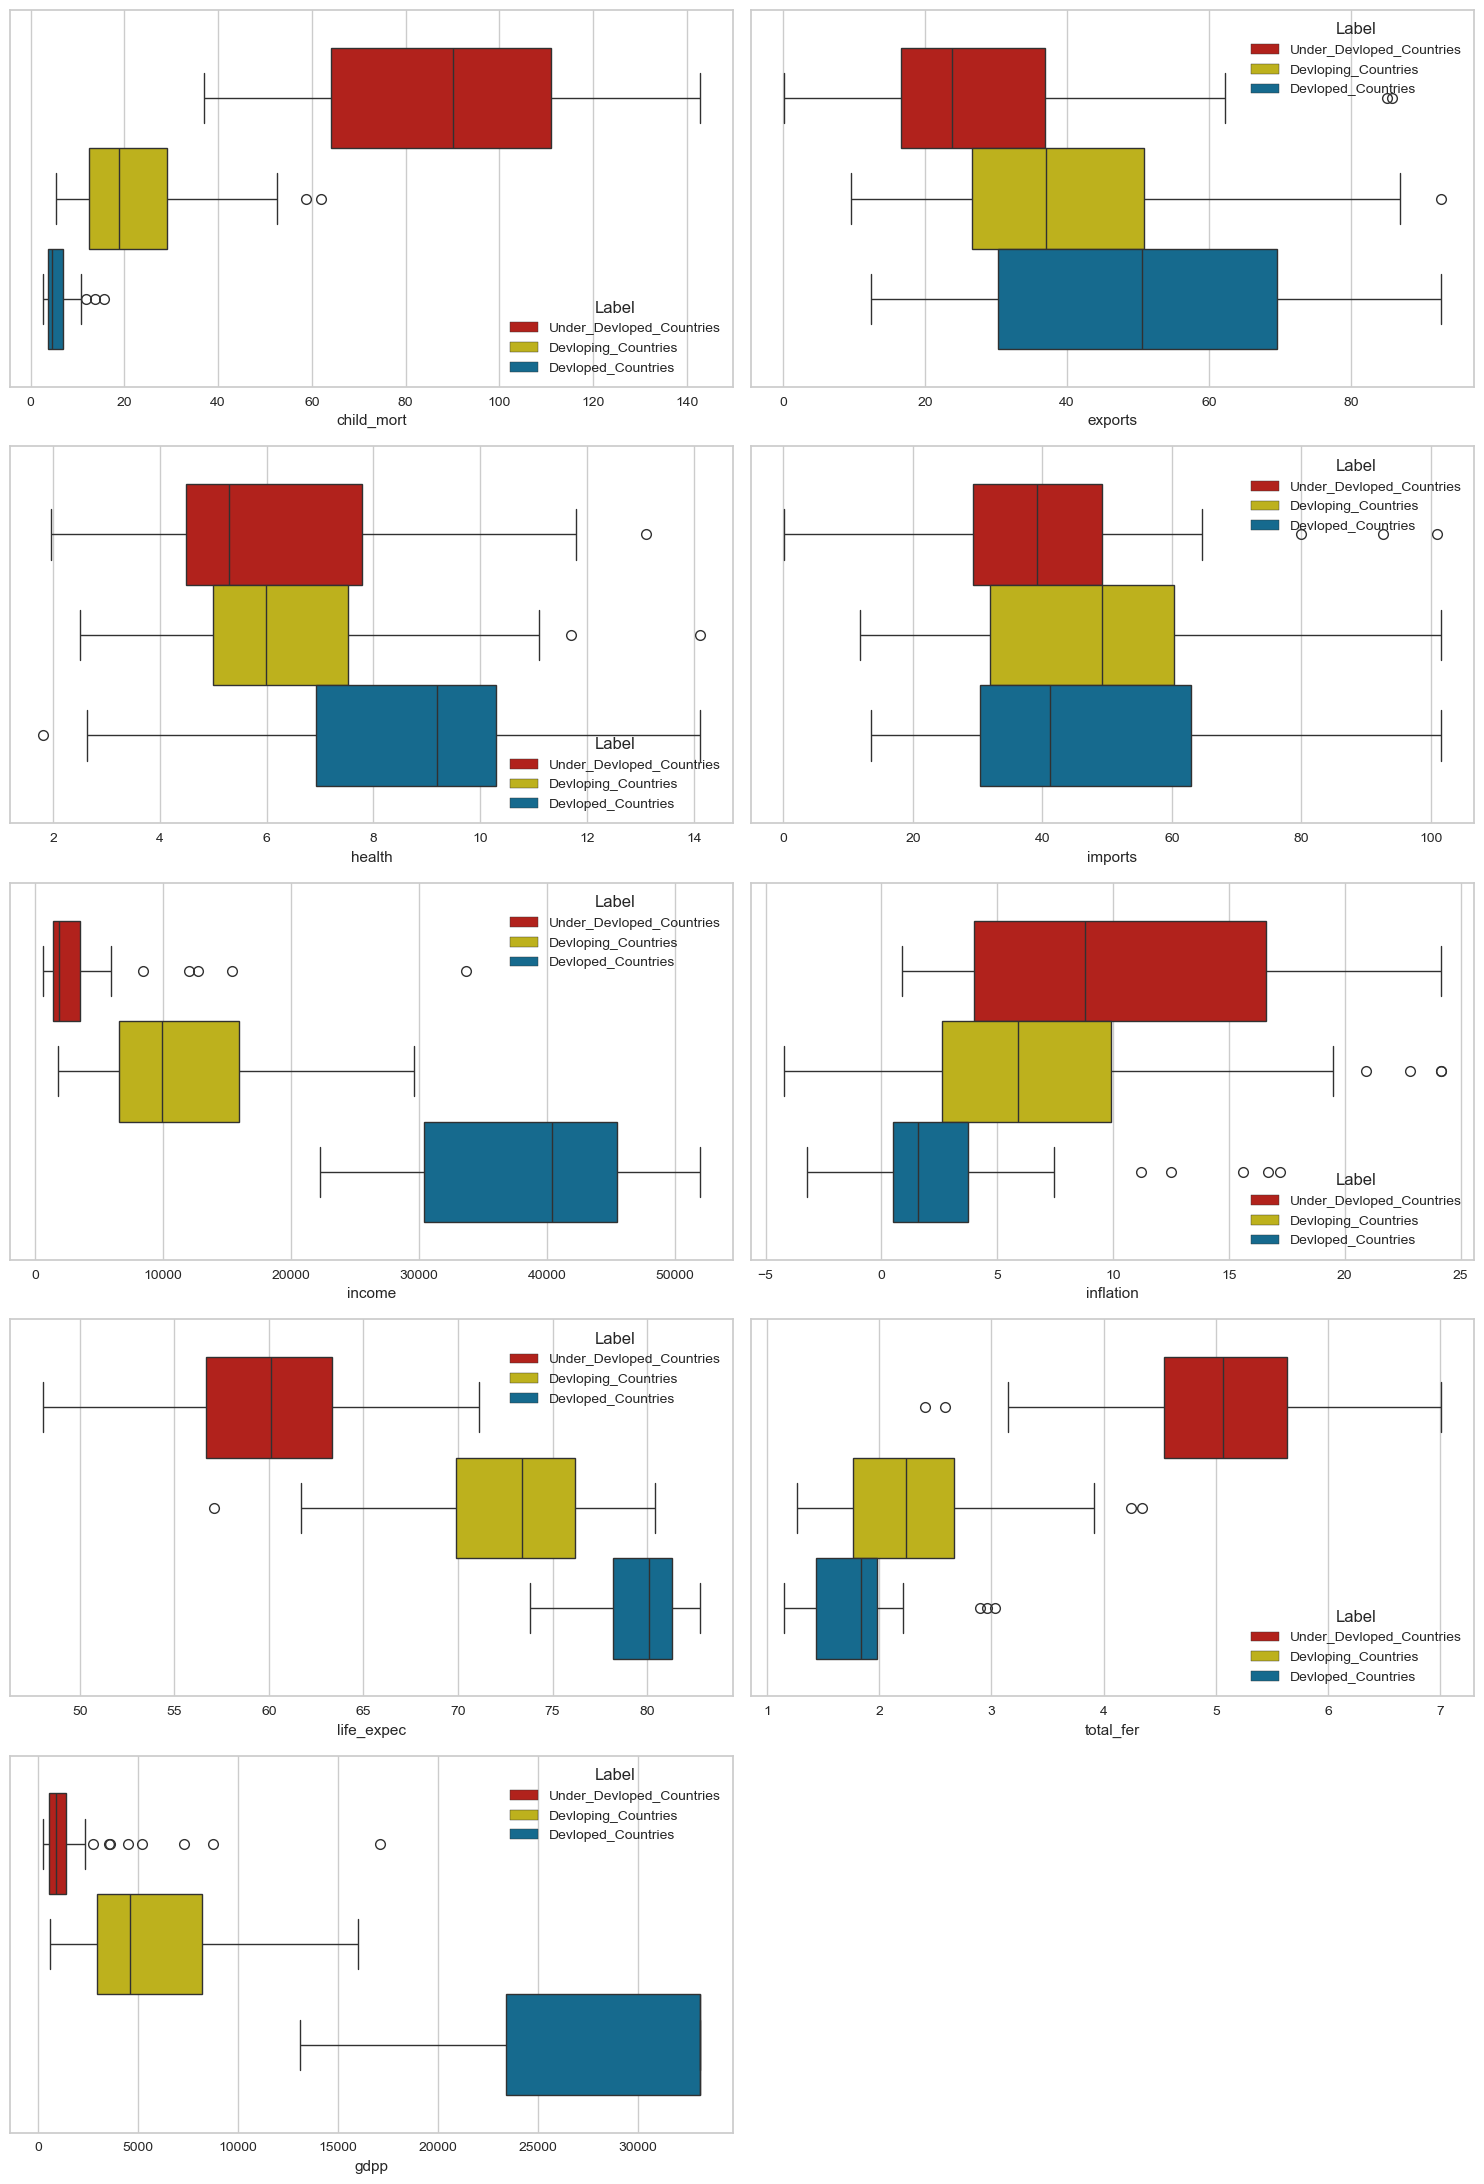

In [63]:
# Lets visualize these classes
t=1
plt.figure(figsize=(15,22))
for i in data:
    if i!='Label':
        plt.subplot(5,2,t)
        sns.boxplot(data=data,x=i,hue='Label',palette=['r','y','b'])
        t=t+1
plt.tight_layout()
plt.show()

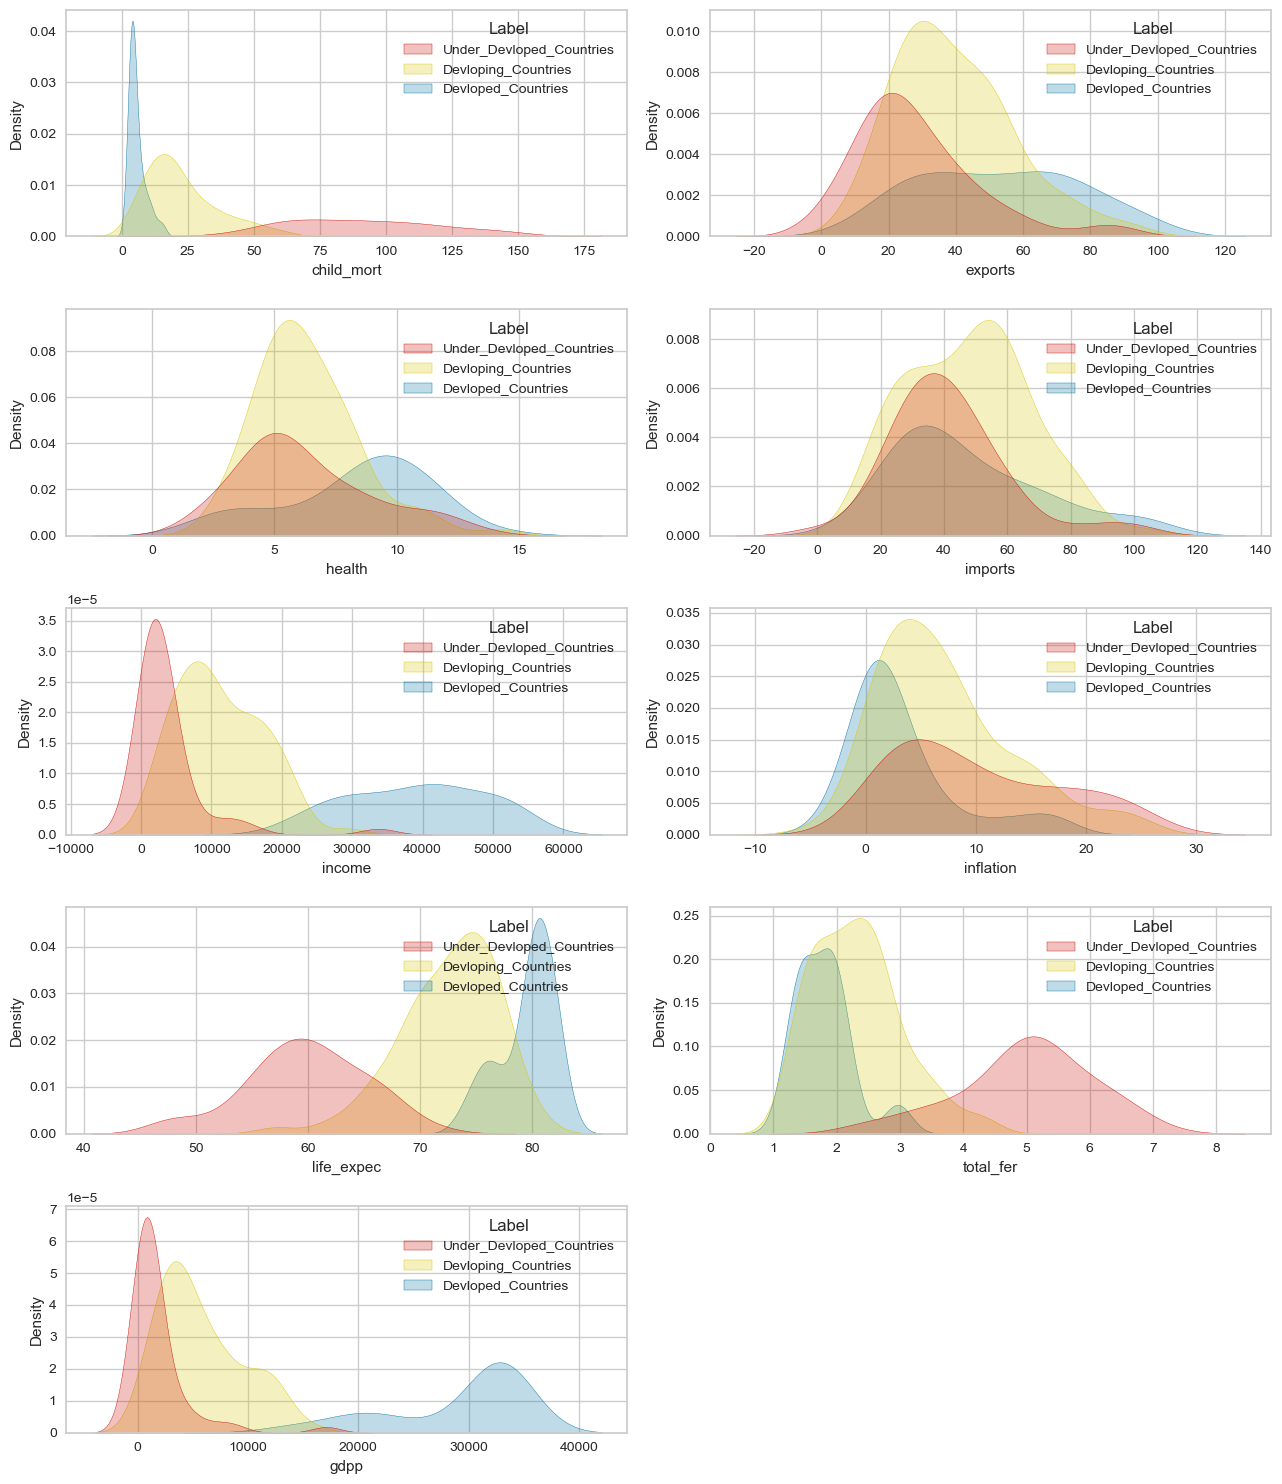

In [64]:
t=1
plt.figure(figsize=(13,15))
for i in data:
    if i!='Label':
        plt.subplot(5,2,t)
        sns.kdeplot(data=data,x=i,hue='Label',palette=['r','y','b'],fill=True)
        t=t+1
plt.tight_layout()
plt.show()

In [65]:
# Lets of countries in both the classes
data[data['Label']=='Under_Devloped_Countries'].index

Index(['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea', 'Eritrea', 'Gabon',
       'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya',
       'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali',
       'Mauritania', 'Mozambique', 'Myanmar', 'Namibia', 'Niger', 'Nigeria',
       'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'South Africa',
       'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen',
       'Zambia'],
      dtype='object', name='country')

In [66]:
data[data['Label']=='Devloped_Countries'].index

Index(['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Brunei',
       'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Kuwait', 'Luxembourg', 'Malta',
       'Netherlands', 'New Zealand', 'Norway', 'Oman', 'Portugal', 'Qatar',
       'Saudi Arabia', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='country')

In [67]:
data[data['Label']=='Devloping_Countries'].index

Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Cambodia', 'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'India',
       'Indonesia', 'Iran', 'Jamaica', 'Jordan', 'Kazakhstan',
       'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania',
       'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
       'Nepal', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russia', 'Samoa', 'Serbia', 'Seychelles', 'Solomon Islands',
       'Sri Lanka', 'St. Vincent and the Grenadines', 'Suriname', 'Tajikistan',
       'Thailand', 'Tonga', 'Tunisia', 'Tu

# World Map

In [69]:
# Create a data of country and label
world_data = pd.DataFrame({'Label':data['Label']})
world_data.reset_index(inplace=True)
world_data

country                     Label
0            Afghanistan  Under_Devloped_Countries
1                Albania       Devloping_Countries
2                Algeria       Devloping_Countries
3                 Angola  Under_Devloped_Countries
4    Antigua and Barbuda       Devloping_Countries
..                   ...                       ...
162              Vanuatu       Devloping_Countries
163            Venezuela       Devloping_Countries
164              Vietnam       Devloping_Countries
165                Yemen  Under_Devloped_Countries
166               Zambia  Under_Devloped_Countries

[167 rows x 2 columns]

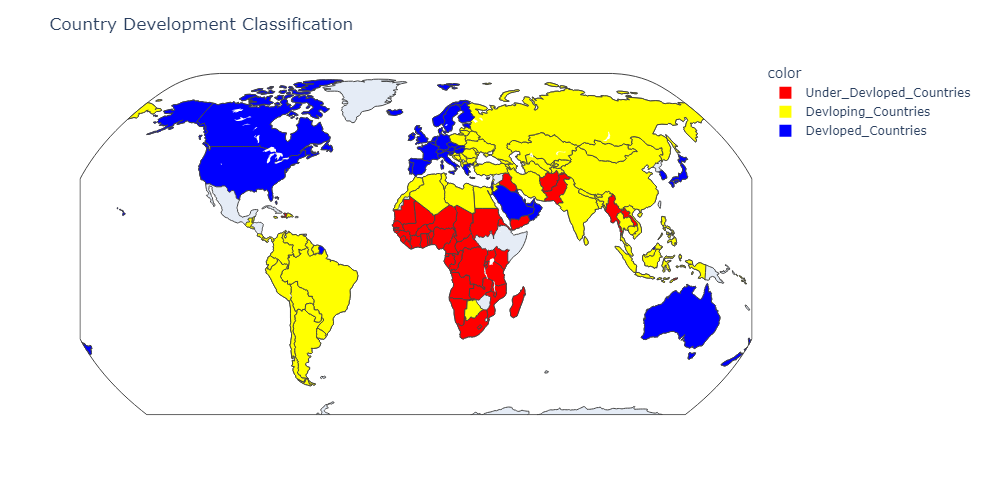

In [70]:
fig = px.choropleth(data_frame=world_data,locationmode='country names',locations=world_data['country'],
                   color=data['Label'],color_discrete_map={'Devloped_Countries':'blue','Under_Devloped_Countries':'red',
                                                                 'Devloping_Countries':'yellow'},width=900,height=500)
fig.update_geos(projection_type='natural earth')
fig.update_layout(title='Country Development Classification')
fig.show()